In [52]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import scipy
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
import random

plt.style.use('seaborn-v0_8-notebook')
%config InlineBackend.figure_format = 'retina' 

In [53]:
carsdata=pd.read_csv('car_price.csv', usecols=range(1, 10))
carsdata.sample(10)

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
2379,Chevrolet Spark 1.0 LT Option Pack,1.30 Lakh,"50,000 kms",Petrol,Manual,2nd Owner,2012,2179 cc,7 Seats
308,Maruti Alto 800 LXI,2.04 Lakh,"45,080 kms",Petrol,Manual,3rd Owner,2015,796 cc,5 Seats
3468,Audi Q3 35 TDI Quattro Premium Plus,25.48 Lakh,"40,996 kms",Diesel,Automatic,1st Owner,2019,1462 cc,5 Seats
2608,Mahindra Scorpio 1.99 S10,7.50 Lakh,"1,30,000 kms",Diesel,Manual,1st Owner,2015,1461 cc,5 Seats
3868,Renault Kiger RXT,7.20 Lakh,"14,000 kms",Petrol,Manual,1st Owner,2022,1396 cc,5 Seats
2024,Maruti Wagon R VXI BS IV,3.50 Lakh,"40,000 kms",Petrol,Manual,4th Owner,2017,1248 cc,5 Seats
3220,Renault KWID RXT,2.49 Lakh,"53,827 kms",Petrol,Manual,1st Owner,2016,1197 cc,5 Seats
4467,Maruti Ertiga SHVS VDI,7 Lakh,"1,57,000 kms",Diesel,Manual,1st Owner,2017,2982 cc,5 Seats
398,Volkswagen Polo Cup Edition Comfortline,6.85 Lakh,"46,000 kms",Petrol,Manual,1st Owner,2017,999 cc,5 Seats
3195,Maruti Ertiga VXI Petrol,7.41 Lakh,"21,197 kms",Petrol,Manual,1st Owner,2019,1497 cc,7 Seats


# DATA CLEANING

<b>CHECKING NULL VALUES</B>

In [54]:
carsdata.isnull().sum()

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

<b> ADJUSTING NUMERIC VALUES AND CHANGING PRICE TO USD</B>

In [55]:
def convert_to_usd(amount): 
    if 'Lakh' in amount:
        rupees = float(amount.split(' ')[0]) * 100_000
        
    elif 'Crore' in amount:
        rupees = float(amount.split(' ')[0]) * 10_000_000
        
    else:
        rupees = float(amount.replace(',', ''))
    
    usd = round(rupees * .012)
    return usd

In [56]:
carsdata["price_in_USD"] = carsdata["car_prices_in_rupee"].apply(convert_to_usd)
carsdata["kms_driven"] = [float(i[:-4].replace(",","")) for i in carsdata["kms_driven"]]
carsdata["engine"] = [float(i[:-3]) for i in carsdata["engine"]]
carsdata["Seats"] = [float(i[:-6]) for i in carsdata["Seats"]]
carsdata.sample(5)


,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,price_in_USD
382,Volkswagen Polo GT TSI,7.25 Lakh,54000.0,Petrol,Automatic,1st Owner,2015,1197.0,5.0,8700
2982,Hyundai i20 Sportz Plus BSIV,6.64 Lakh,35986.0,Petrol,Manual,1st Owner,2019,1461.0,5.0,7968
1947,Volkswagen Vento Petrol Highline AT,2.73 Lakh,71760.0,Petrol,Automatic,1st Owner,2010,1248.0,5.0,3276
3462,BMW 7 Series 730Ld,12.97 Lakh,104033.0,Diesel,Automatic,3rd Owner,2010,1498.0,5.0,15564
4290,Hyundai i20 Magna 1.2,5.35 Lakh,81000.0,Petrol,Manual,1st Owner,2017,1798.0,5.0,6420


In [57]:
carsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_name             5512 non-null   object 
 1   car_prices_in_rupee  5512 non-null   object 
 2   kms_driven           5512 non-null   float64
 3   fuel_type            5512 non-null   object 
 4   transmission         5512 non-null   object 
 5   ownership            5512 non-null   object 
 6   manufacture          5512 non-null   int64  
 7   engine               5512 non-null   float64
 8   Seats                5512 non-null   float64
 9   price_in_USD         5512 non-null   int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 430.8+ KB


<b> CHECKING CATEGORICAL VARIABLES </B>

In [58]:
print(carsdata["fuel_type"].unique())
print(carsdata["transmission"].unique())
print(carsdata["ownership"].unique())

['Diesel' 'Petrol' 'Cng' 'Electric' 'Lpg']
['Manual' 'Automatic']
['1st Owner' '2nd Owner' '3rd Owner' '4th Owner' '5th Owner' '0th Owner']


In [59]:
carsdata[carsdata["ownership"] == '0th Owner'].shape[0]

7

There are 7 registers described as '0th Owner'. We are removing those registers.

In [60]:
carsdata = carsdata.loc[carsdata["ownership"] != '0th Owner']

In [61]:
carsdata.shape[0]

5505

In [62]:
# OPTIONAL - TAILOR THE DATA !!!!!
#carsdata = carsdata[carsdata["price_in_USD"]<3200]
#carsdata = carsdata[(carsdata["price_in_USD"]>3200) & (carsdata["price_in_USD"]<22000)]
#carsdata = carsdata[(carsdata["price_in_USD"]>22000)]
carsdata.shape[0]

5505

# CHECKING FOR MULTICOLLINEARITY

In [63]:
carsdata

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,price_in_USD
0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,86226.0,Diesel,Manual,1st Owner,2017,1956.0,5.0,12036
1,Renault Duster RXZ Turbo CVT,12.83 Lakh,13248.0,Petrol,Automatic,1st Owner,2021,1330.0,5.0,15396
2,Toyota Camry 2.5 G,16.40 Lakh,60343.0,Petrol,Automatic,1st Owner,2016,2494.0,5.0,19680
3,Honda Jazz VX CVT,7.77 Lakh,26696.0,Petrol,Automatic,1st Owner,2018,1199.0,5.0,9324
4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,69414.0,Petrol,Manual,1st Owner,2016,1199.0,5.0,6180
...,...,...,...,...,...,...,...,...,...,...
5507,BMW X1 sDrive 20d xLine,28.90 Lakh,45000.0,Diesel,Automatic,1st Owner,2018,2995.0,7.0,34680
5508,BMW M Series M4 Coupe,64.90 Lakh,29000.0,Petrol,Automatic,2nd Owner,2015,1968.0,5.0,77880
5509,Jaguar XF 2.2 Litre Luxury,13.75 Lakh,90000.0,Diesel,Automatic,2nd Owner,2013,2755.0,5.0,16500
5510,BMW 7 Series 730Ld,29.90 Lakh,79000.0,Diesel,Automatic,3rd Owner,2015,2967.0,6.0,35880


/var/folders/g9/q6tzypkx56110bt4s_wsr1y40000gn/T/ipykernel_74044/1711231949.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = carsdata.corr().round(2)


<Axes: >

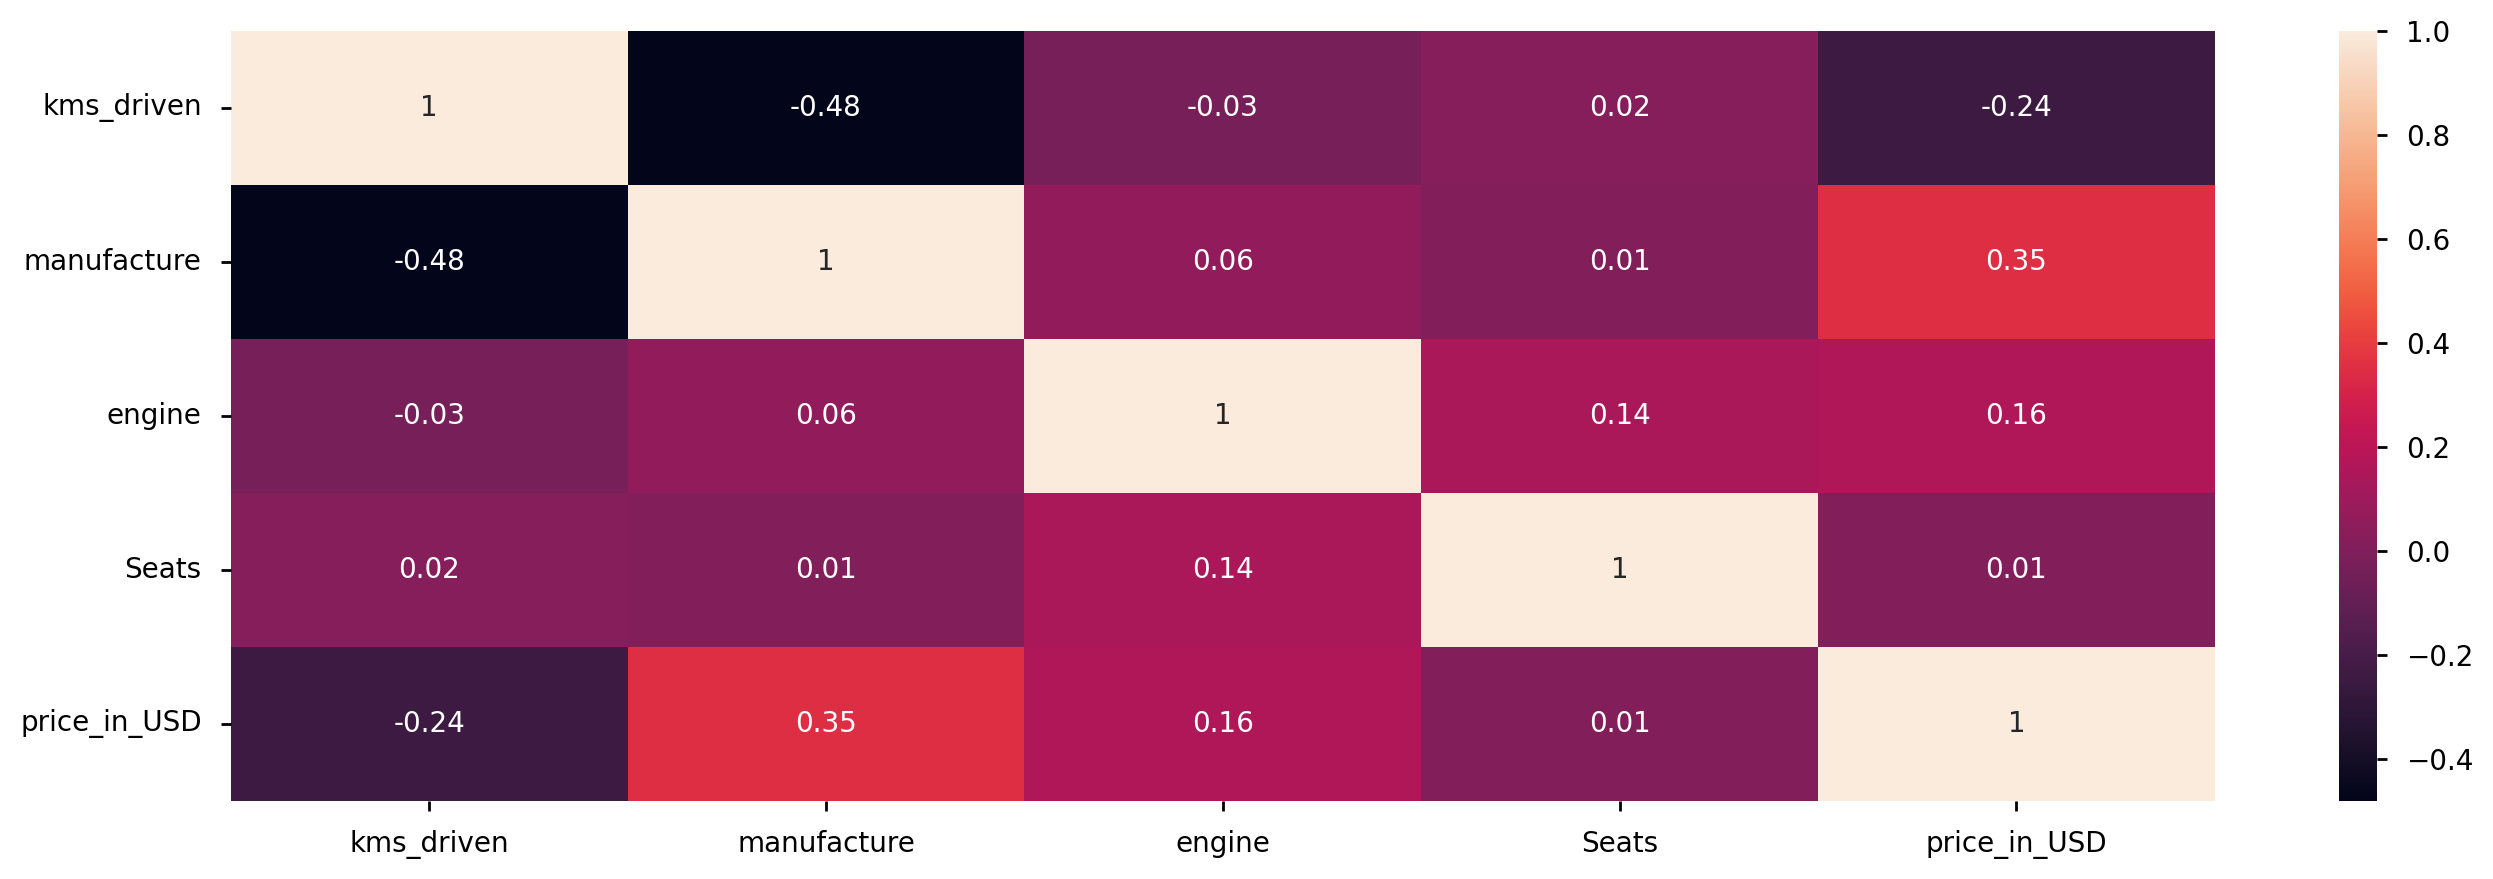

In [64]:
correlation_matrix = carsdata.corr().round(2)
plt.figure(figsize = (16,5))
sns.heatmap(data=correlation_matrix, annot=True)

In [65]:
y, X = dmatrices('price_in_USD~kms_driven+manufacture+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)', data=carsdata, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

       VIF Factor                   features
0   421224.169097                  Intercept
1       17.759448     C(fuel_type)[T.Diesel]
2        1.186813   C(fuel_type)[T.Electric]
3        1.358954        C(fuel_type)[T.Lpg]
4       17.760131     C(fuel_type)[T.Petrol]
5        1.156486  C(transmission)[T.Manual]
6        1.158506  C(ownership)[T.2nd Owner]
7        1.145112  C(ownership)[T.3rd Owner]
8        1.052488  C(ownership)[T.4th Owner]
9        1.012981  C(ownership)[T.5th Owner]
10       1.504608                 kms_driven
11       1.588007                manufacture
12       1.058015                     engine
13       1.024558                      Seats


GVIF function from [StackOverflow](https://stats.stackexchange.com/questions/409529/how-is-gvif-calculated-for-categorical-variablesalso-is-there-any-other-way-to).

In [66]:
def calculate_GVIF(all_vars, var):

    """Calculate GVIF between one non-numeric variarble (var) and other variables (all_vars)"""

    # Create correlation matrix (A) of non-numeric variable (var)
    A = pd.get_dummies(all_vars[var], drop_first = True).corr().to_numpy()
    
    # Seperate non-numeric variable name (var) from other variable names
    columns = list(all_vars.columns)
    columns.remove(var)

    # Create correlation matrix (B) of other variables
    B = pd.get_dummies(all_vars[columns], drop_first = True).corr().to_numpy()

    # Create correlation matrix (C) of all variables
    C = pd.get_dummies(all_vars, drop_first = True).corr().to_numpy()

    # Calculate GVIF
    GVIF = (np.linalg.det(A)*np.linalg.det(B)) / np.linalg.det(C)

    return GVIF

In [67]:
carsdata['is_diesel'] = np.where(carsdata['fuel_type'] == 'Diesel', 1, 0)
carsdata['is_electric'] = np.where(carsdata['fuel_type'] == 'Electric', 1, 0)
carsdata["is_petrol"] = np.where(carsdata['fuel_type'] == 'Petrol', 1, 0)

In [68]:
formula = 'is_petrol ~ ownership+engine+Seats+manufacture+kms_driven'

In [69]:
model = smf.glm(formula = formula, data=carsdata, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              is_petrol   No. Observations:                 5505
Model:                            GLM   Df Residuals:                     5496
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3384.0
Date:                Wed, 11 Oct 2023   Deviance:                       6768.0
Time:                        22:15:10   Pearson chi2:                 4.57e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1403
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                316.0912     20.668     15.294      0.000     275.582     356.600
ownership[T.2nd Owner]    -0.4184      0.074     -5.681      0.000      -0.563      -0.274
ownership[T.3rd Owner]    -0.1539      0.127     -1.208      0.227      -0.404       0.096
ownership[T.4th Owner]     0.1431      0.251      0.571      0.568      -0.348       0.634
ownership[T.5th Owner]     0.2617      0.648      0.404      0.686      -1.007       1.531
engine                    -0.0003   5.15e-05     -6.057      0.000      -0.000      -0.000
Seats                     -0.1382      0.041     -3.393      0.001      -0.218      -0.058
manufacture               -0.1553      0.010    -15.179      0.000      -0.175      -0.135
kms_driven             -2.522e-05   1.09e-06    -23.207      0.000   -2.74e-05   -2.31e-05
==========================================================================================
"""

Despite VIF is low, kms_driven and manufacture have a High negative correlation coeficient. which is not desirable for our model.
We will eliminate kms_driven predictor

# MODELING 1

<b> MODELING 1A</B>

In [70]:
model1A = smf.ols('price_in_USD~manufacture+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)',data=carsdata).fit()
model1A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_in_USD   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     247.0
Date:                Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:15:10   Log-Likelihood:                -62057.
No. Observations:                5505   AIC:                         1.241e+05
Df Residuals:                    5492   BIC:                         1.242e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -2.582e+06   1.52e+05    -17.003      0.000   -2.88e+06   -2.28e+06
C(fuel_type)[T.Diesel]     6382.4001   2179.389      2.929      0.003    2109.934    1.07e+04
C(fuel_type)[T.Electric]  -1.735e+04   5555.214     -3.123      0.002   -2.82e+04   -6458.587
C(fuel_type)[T.Lpg]        5706.1793   4207.881      1.356      0.175   -2542.933     1.4e+04
C(fuel_type)[T.Petrol]     1522.1643   2167.290      0.702      0.482   -2726.583    5770.912
C(transmission)[T.Manual]  -2.39e+04    607.874    -39.319      0.000   -2.51e+04   -2.27e+04
C(ownership)[T.2nd Owner] -2273.4086    647.582     -3.511      0.000   -3542.927   -1003.891
C(ownership)[T.3rd Owner] -2755.5251   1111.135     -2.480      0.013   -4933.789    -577.261
C(ownership)[T.4th Owner]  -104.6306   2147.261     -0.049      0.961   -4314.113    4104.852
C(ownership)[T.5th Owner]  3995.4864   5540.833      0.721      0.471   -6866.741    1.49e+04
manufacture                1293.8717     75.212     17.203      0.000    1146.426    1441.318
engine                        2.5027      0.456      5.489      0.000       1.609       3.397
Seats                      -174.8589    360.857     -0.485      0.628    -882.281     532.563
==============================================================================
Omnibus:                     5794.046   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           445404.611
Skew:                           5.250   Prob(JB):                         0.00
Kurtosis:                      45.797   Cond. No.                     1.51e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b> CHECK FOR INFLUENTIAL POINTS </B>

In [71]:
infl = model1A.get_influence()

In [72]:
# Studentized external
n=model1A.nobs
p=13
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
print(carsdata.index[atyp_stud],reg_studs[atyp_stud])

Int64Index([ 119,  205,  227,  283,  315,  531,  596,  607,  632,  697,
            ...
            5410, 5422, 5434, 5438, 5458, 5470, 5479, 5482, 5483, 5508],
           dtype='int64', length=137) [ 4.96054485  2.17311621  2.55554676  2.40825893  5.79266964  2.0196824
  3.90961676  2.20274833  2.68112745  4.0904043   2.01755564  2.35494239
  2.40619466  2.69142838  2.35372145  7.8937382   5.44973118  3.01859678
 10.43699639  2.30154722  2.2177756   2.35179577  8.74555398  8.84658743
  8.12117818  9.23596418  2.65238545  3.98139901  2.47197777  2.65179862
  2.48657557  3.53032629  2.31488636  8.05313811  5.29763672  2.09309567
  3.04862159  2.75849969  2.30686164 10.33271523  2.10957334  2.34700692
  3.48564445  2.58635429  3.96198497  2.53812967 10.00409924  2.6802229
  5.32333611  2.54607002  5.95611641  3.52355908  2.32728973  8.04620287
  2.0462674   1.98968036  6.12689035  2.58214094  2.17413848  2.70390417
  5.89051505  2.45180052  9.09522587  9.16219639  3.37737069  2.46090121


In [73]:
#Cook's distance
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(carsdata.index[atyp_cook],reg_cook[atyp_cook])

Int64Index([ 119,  205,  227,  283,  288,  315,  370,  595,  596,  632,
            ...
            5374, 5406, 5438, 5458, 5474, 5475, 5479, 5482, 5483, 5508],
           dtype='int64', length=108) 119     0.004241
205     0.000753
227     0.001129
283     0.001143
288     0.001533
          ...   
5475    0.001046
5479    0.000870
5482    0.008309
5483    0.019741
5508    0.000863
Name: cooks_d, Length: 108, dtype: float64


In [74]:
# Common points
common = list(set(carsdata.index[atyp_stud]) & set(carsdata.index[atyp_cook]))
#Save Outliers for future analysis
mask = carsdata.index.isin(common)
outliers = carsdata[mask]


Let´s delete those influential points that has been identified by both methods

In [75]:
carsdata = carsdata.drop(common)

<b> MODELING 1B</B>

In [76]:
model1B = smf.ols('price_in_USD~manufacture+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)',data=carsdata).fit()
model1B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_in_USD   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     443.8
Date:                Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:15:21   Log-Likelihood:                -58052.
No. Observations:                5423   AIC:                         1.161e+05
Df Residuals:                    5410   BIC:                         1.162e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -2.037e+06   8.64e+04    -23.579      0.000   -2.21e+06   -1.87e+06
C(fuel_type)[T.Diesel]     5981.3432   1235.047      4.843      0.000    3560.154    8402.533
C(fuel_type)[T.Electric]  -1.049e+04   3148.321     -3.331      0.001   -1.67e+04   -4315.670
C(fuel_type)[T.Lpg]        3881.3750   2384.225      1.628      0.104    -792.666    8555.417
C(fuel_type)[T.Petrol]     1012.8376   1228.056      0.825      0.410   -1394.646    3420.322
C(transmission)[T.Manual] -1.813e+04    349.355    -51.906      0.000   -1.88e+04   -1.74e+04
C(ownership)[T.2nd Owner] -1682.0417    368.715     -4.562      0.000   -2404.872    -959.212
C(ownership)[T.3rd Owner] -2281.6708    629.783     -3.623      0.000   -3516.300   -1047.042
C(ownership)[T.4th Owner]  -587.0900   1216.763     -0.483      0.629   -2972.435    1798.255
C(ownership)[T.5th Owner]  2402.0748   3139.472      0.765      0.444   -3752.554    8556.704
manufacture                1021.4871     42.784     23.876      0.000     937.614    1105.361
engine                        1.6252      0.262      6.208      0.000       1.112       2.138
Seats                      -302.3028    207.080     -1.460      0.144    -708.263     103.657
==============================================================================
Omnibus:                     2243.405   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14213.771
Skew:                           1.862   Prob(JB):                         0.00
Kurtosis:                      10.003   Cond. No.                     1.50e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b> HETEROCEDASTICITY </B>


Text(0.5, 1.0, 'Fitted Values vs. Residuals')

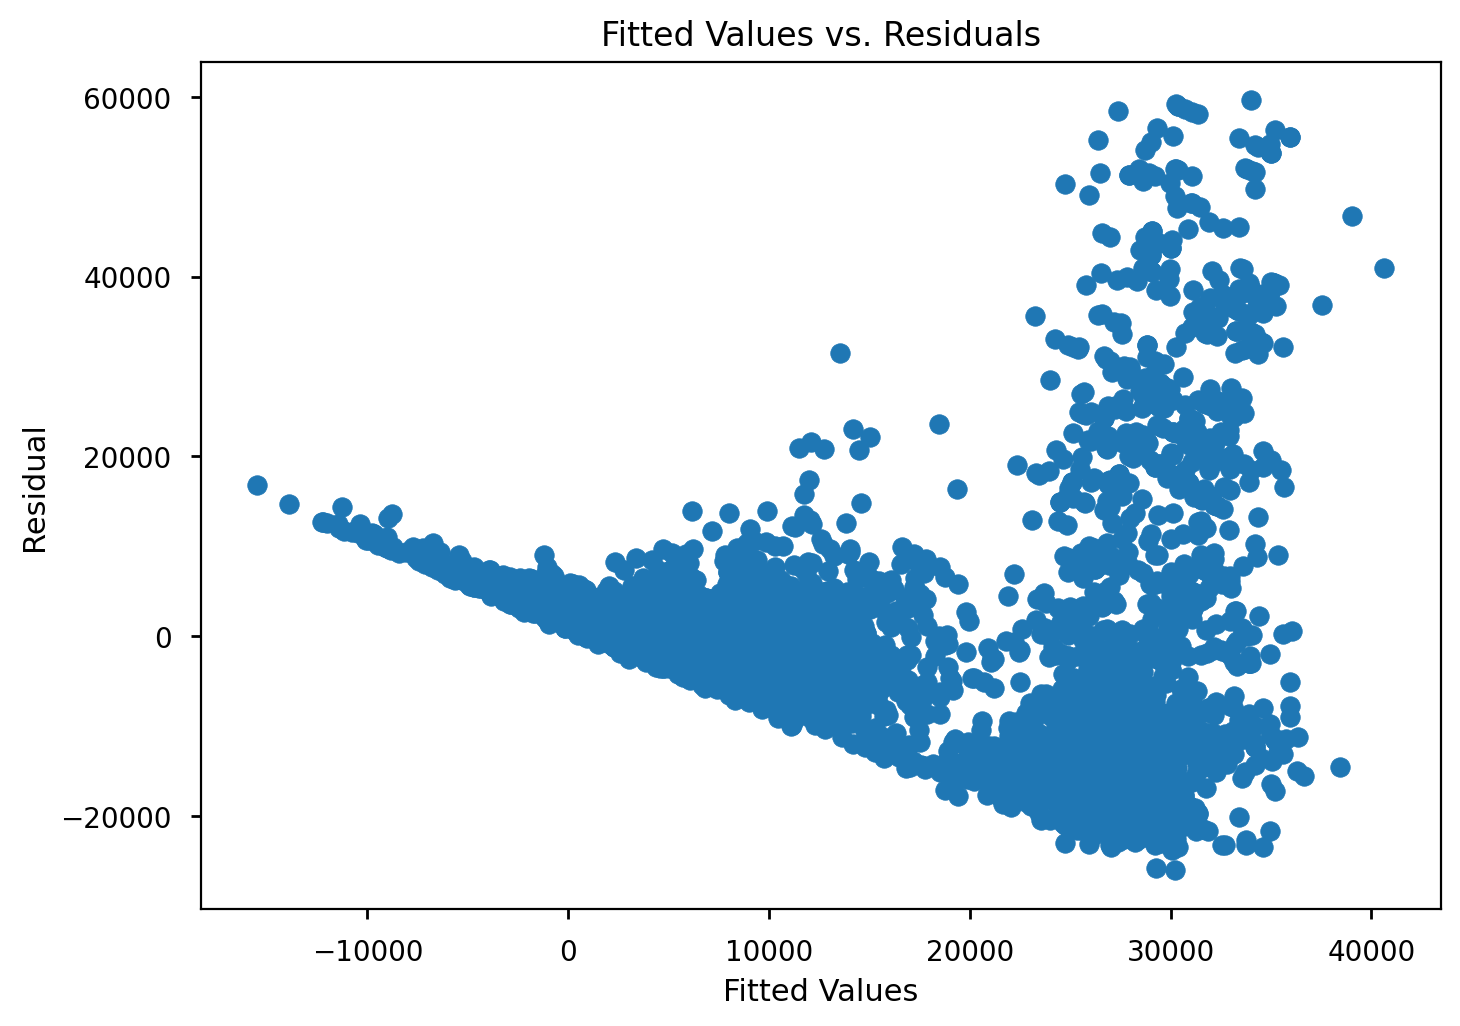

In [77]:
#Fitted Values vs. Residuals Plot
fitted1B = model1B.fittedvalues
res1B = model1B.resid
plt.scatter(fitted1B,res1B)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

In [78]:
#Breusch-Pagan test
bp_test = het_breuschpagan(model1B.resid, model1B.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 1339.7531501507722, 'LM-Test p-value': 1.350023909881456e-279}


There is a significant evidence of heterocedasticity.

<b> NORMALITY</B>

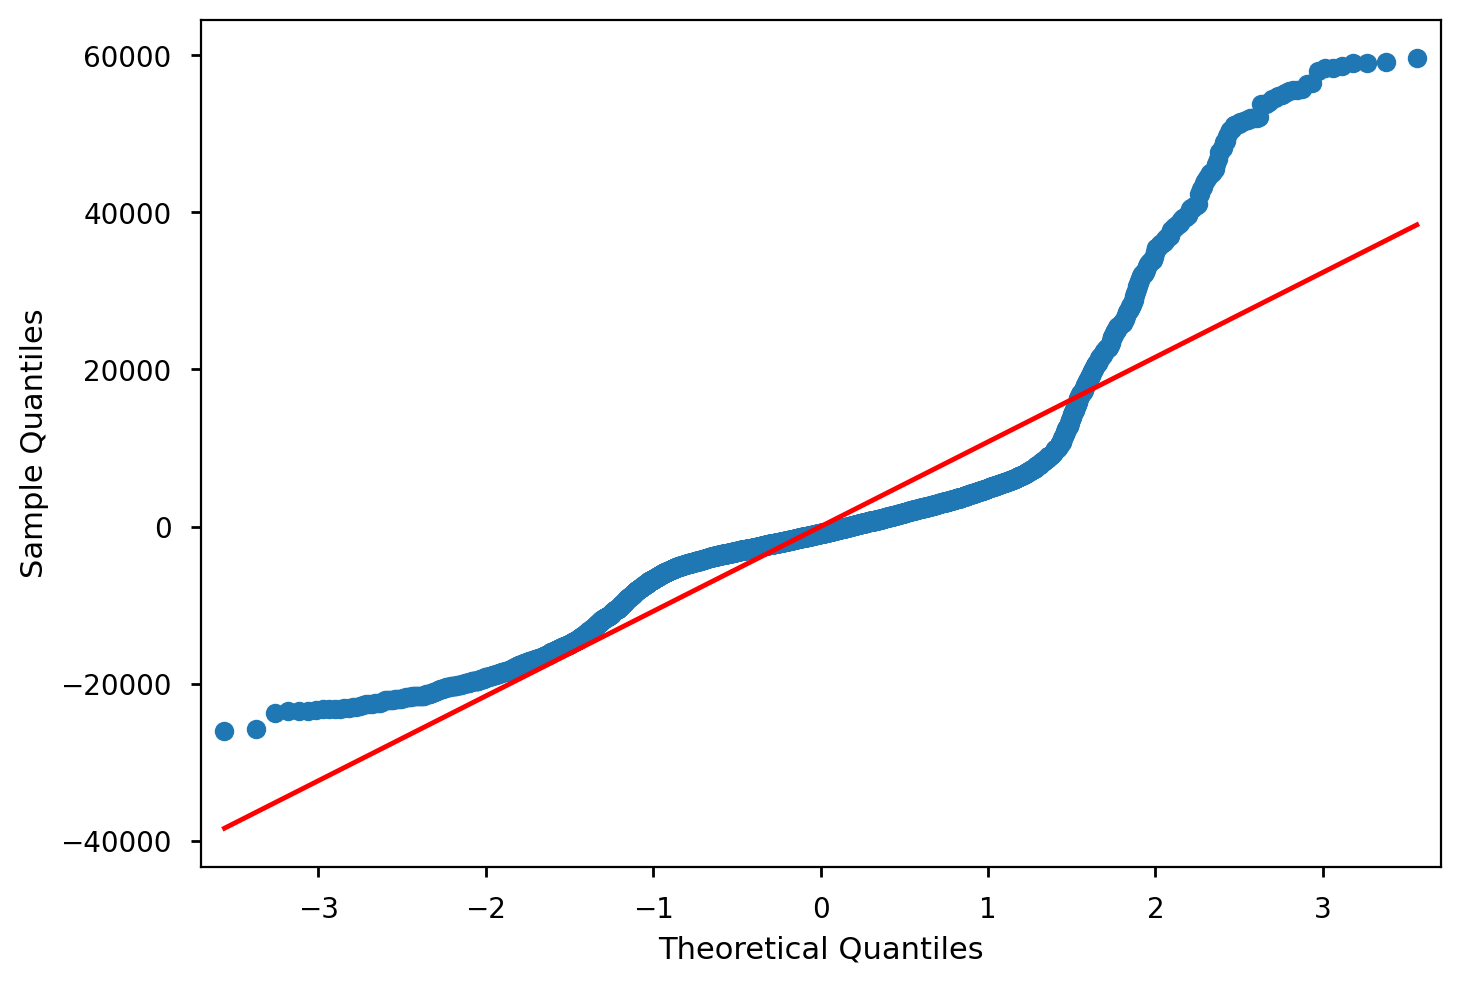

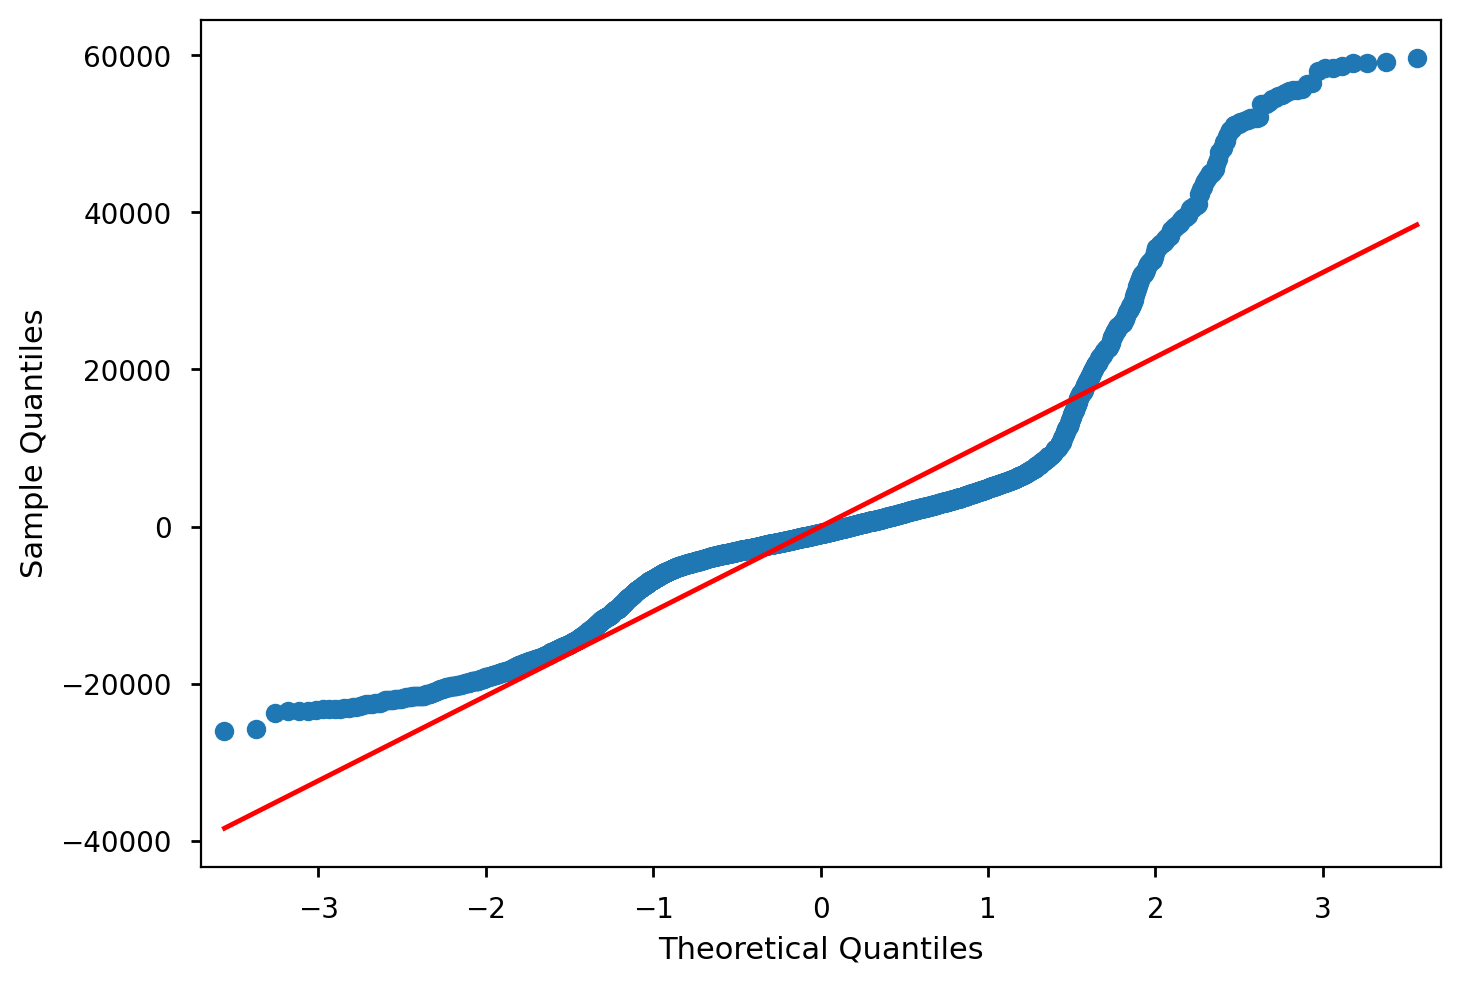

In [79]:
#qq plot
sm.qqplot(model1B.resid,line='s')


In [80]:
#jarque-Bera Test
jarque = stats.jarque_bera(res1B)
jarque.statistic

14213.771194185445

In [81]:
jarque.pvalue

0.0

There is a significant evidence of non-normality.

<b> NONLINEARITY BETWEEN X AND Y </B>

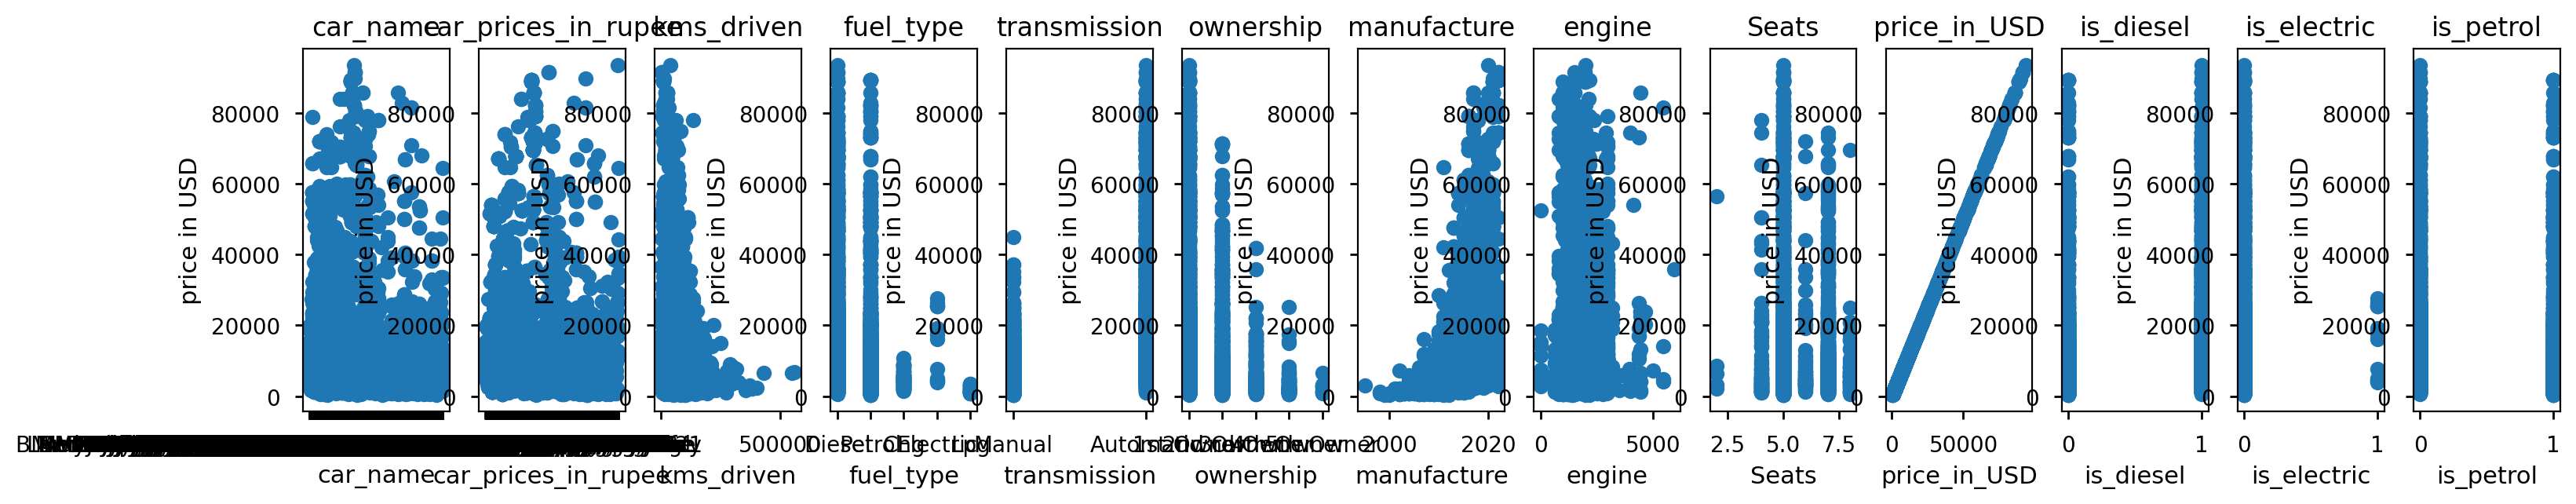

In [82]:
#pair-wise scatter plot between y and predictors
plt.figure(figsize=(20, 3))

for i, col in enumerate(carsdata.columns):
    plt.subplot(1, 14, i+1)
    x = carsdata[col]
    y = carsdata['price_in_USD']
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price in USD')


<b> A TRANSFORMATION IS REQUIRED</B>

<b> OPTION 1: NATURAL-LOG TRANSFORMATION</B>

In [83]:
carsdata['log_price']=np.log(carsdata['price_in_USD'])

<b> MODELING 1C</B>

In [84]:
model1C = smf.ols('log_price~manufacture+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)',data=carsdata).fit()
model1C.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     1276.
Date:                Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:15:28   Log-Likelihood:                -3886.9
No. Observations:                5423   AIC:                             7800.
Df Residuals:                    5410   BIC:                             7886.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -243.9300      3.970    -61.448      0.000    -251.712    -236.148
C(fuel_type)[T.Diesel]        0.5884      0.057     10.369      0.000       0.477       0.700
C(fuel_type)[T.Electric]     -0.4036      0.145     -2.790      0.005      -0.687      -0.120
C(fuel_type)[T.Lpg]          -0.1562      0.110     -1.426      0.154      -0.371       0.059
C(fuel_type)[T.Petrol]        0.1296      0.056      2.297      0.022       0.019       0.240
C(transmission)[T.Manual]    -1.0379      0.016    -64.655      0.000      -1.069      -1.006
C(ownership)[T.2nd Owner]    -0.0667      0.017     -3.936      0.000      -0.100      -0.033
C(ownership)[T.3rd Owner]    -0.1949      0.029     -6.734      0.000      -0.252      -0.138
C(ownership)[T.4th Owner]    -0.3014      0.056     -5.391      0.000      -0.411      -0.192
C(ownership)[T.5th Owner]    -0.1422      0.144     -0.986      0.324      -0.425       0.141
manufacture                   0.1256      0.002     63.869      0.000       0.122       0.129
engine                     8.461e-05    1.2e-05      7.035      0.000     6.1e-05       0.000
Seats                         0.0154      0.010      1.621      0.105      -0.003       0.034
==============================================================================
Omnibus:                       36.753   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.267
Skew:                          -0.082   Prob(JB):                     1.22e-11
Kurtosis:                       3.442   Cond. No.                     1.50e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b> HETEROCEDASTICITY </B>


Text(0.5, 1.0, 'Fitted Values vs. Residuals after log transformation on y')

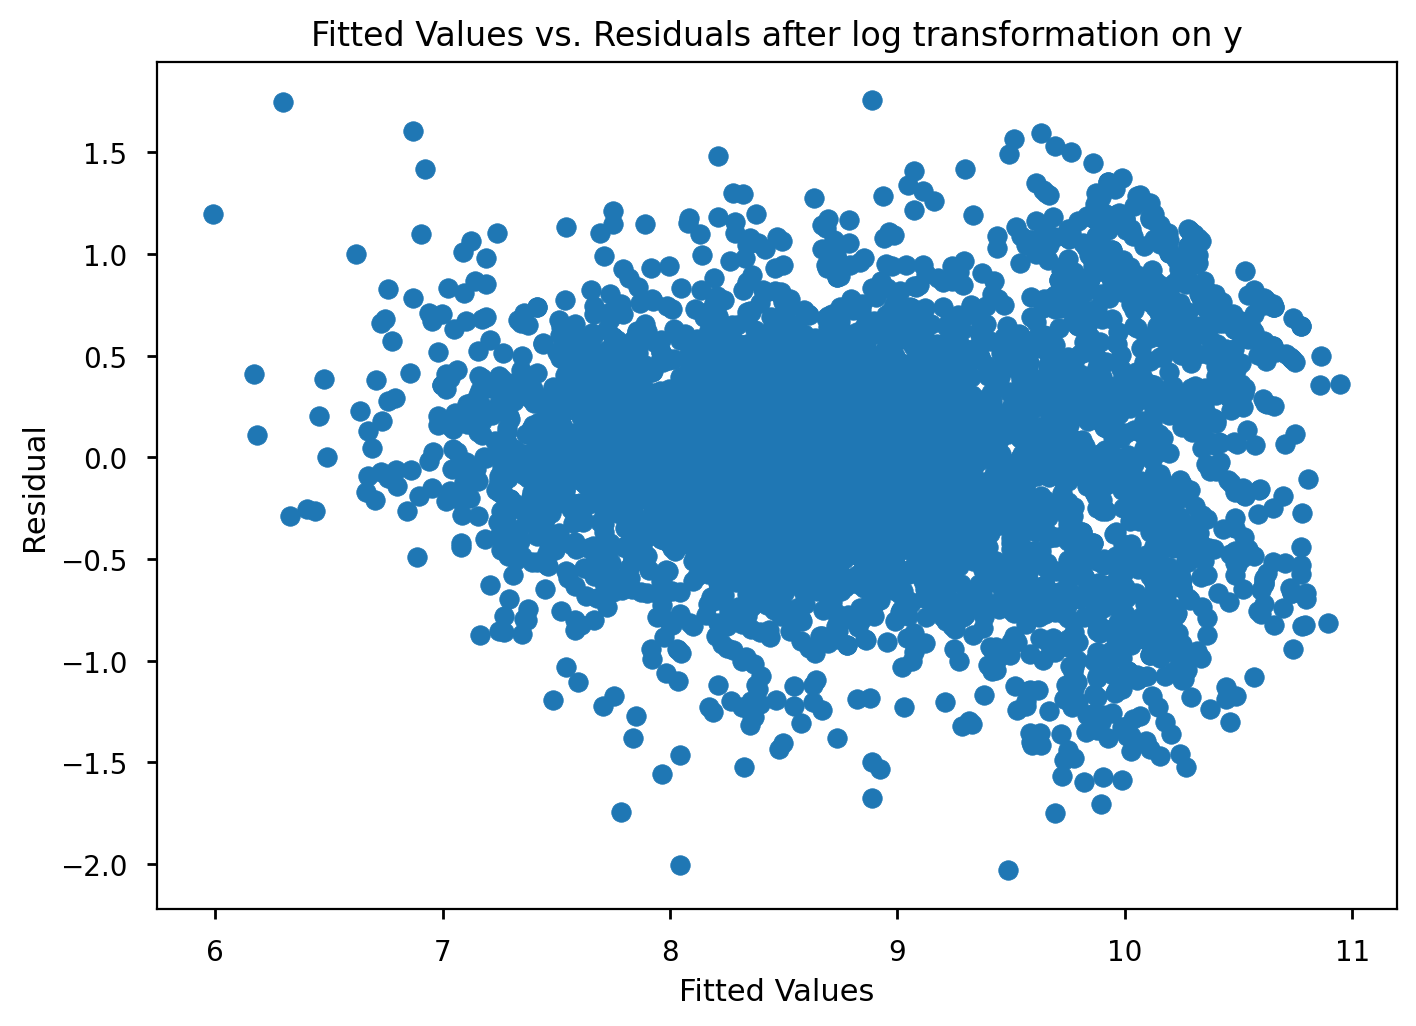

In [85]:
fitted1C = model1C.fittedvalues
res1C = model1C.resid
plt.scatter(fitted1C,res1C)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals after log transformation on y")

In [86]:
#Breusch-Pagan test
bp_test = het_breuschpagan(model1C.resid, model1C.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 720.5313042008413, 'LM-Test p-value': 1.7725596095891156e-146}


Natural-Log transformation was not enough to eliminate heterocedasticity 

<b> NORMALITY</B>

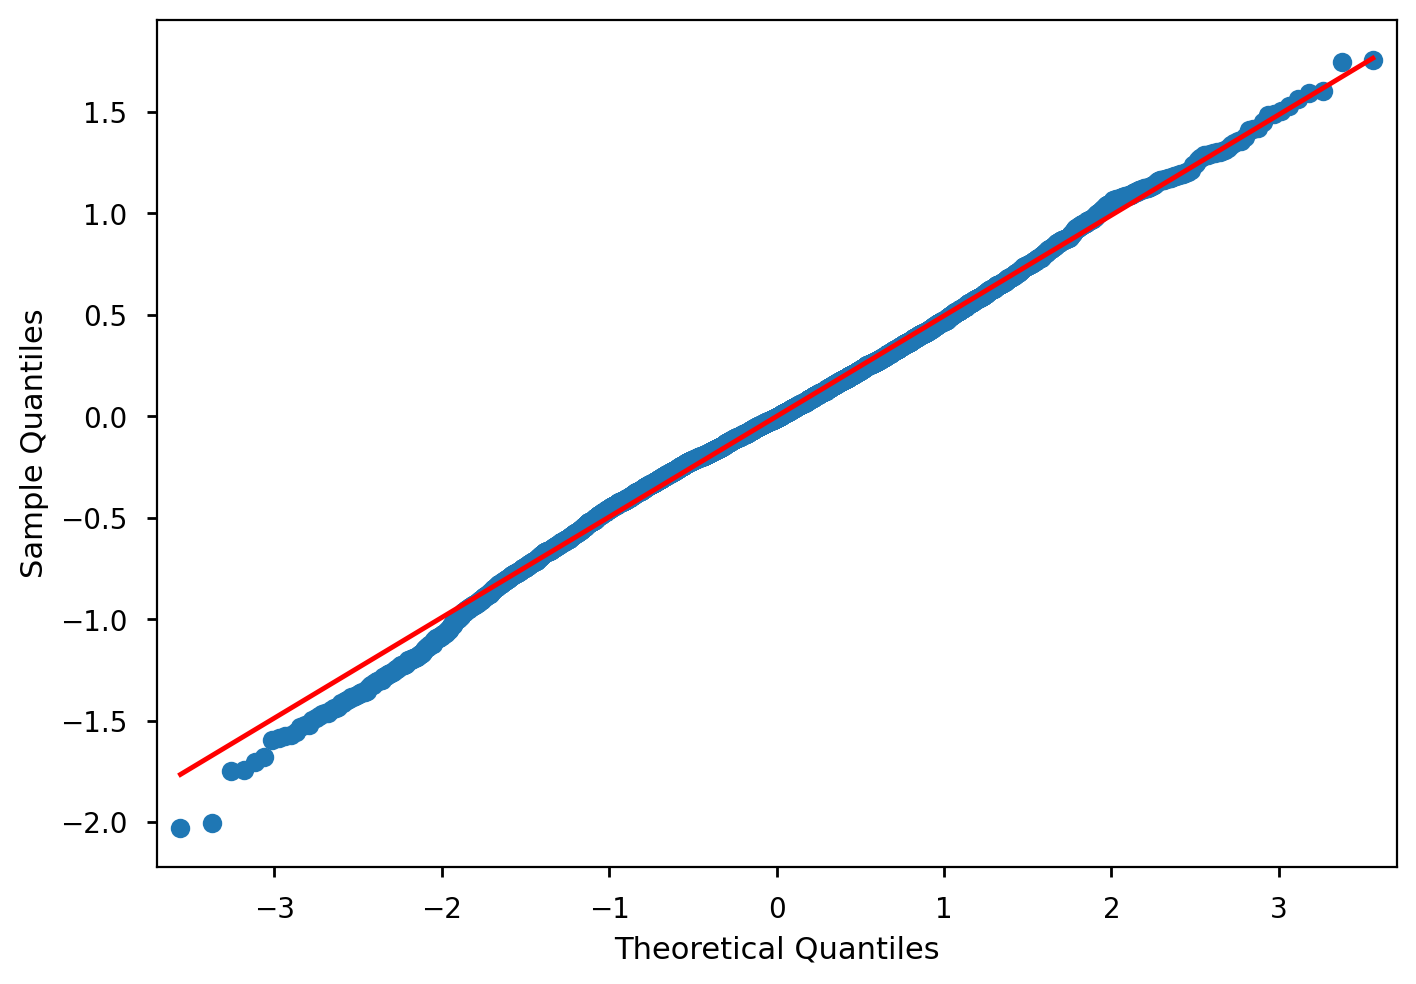

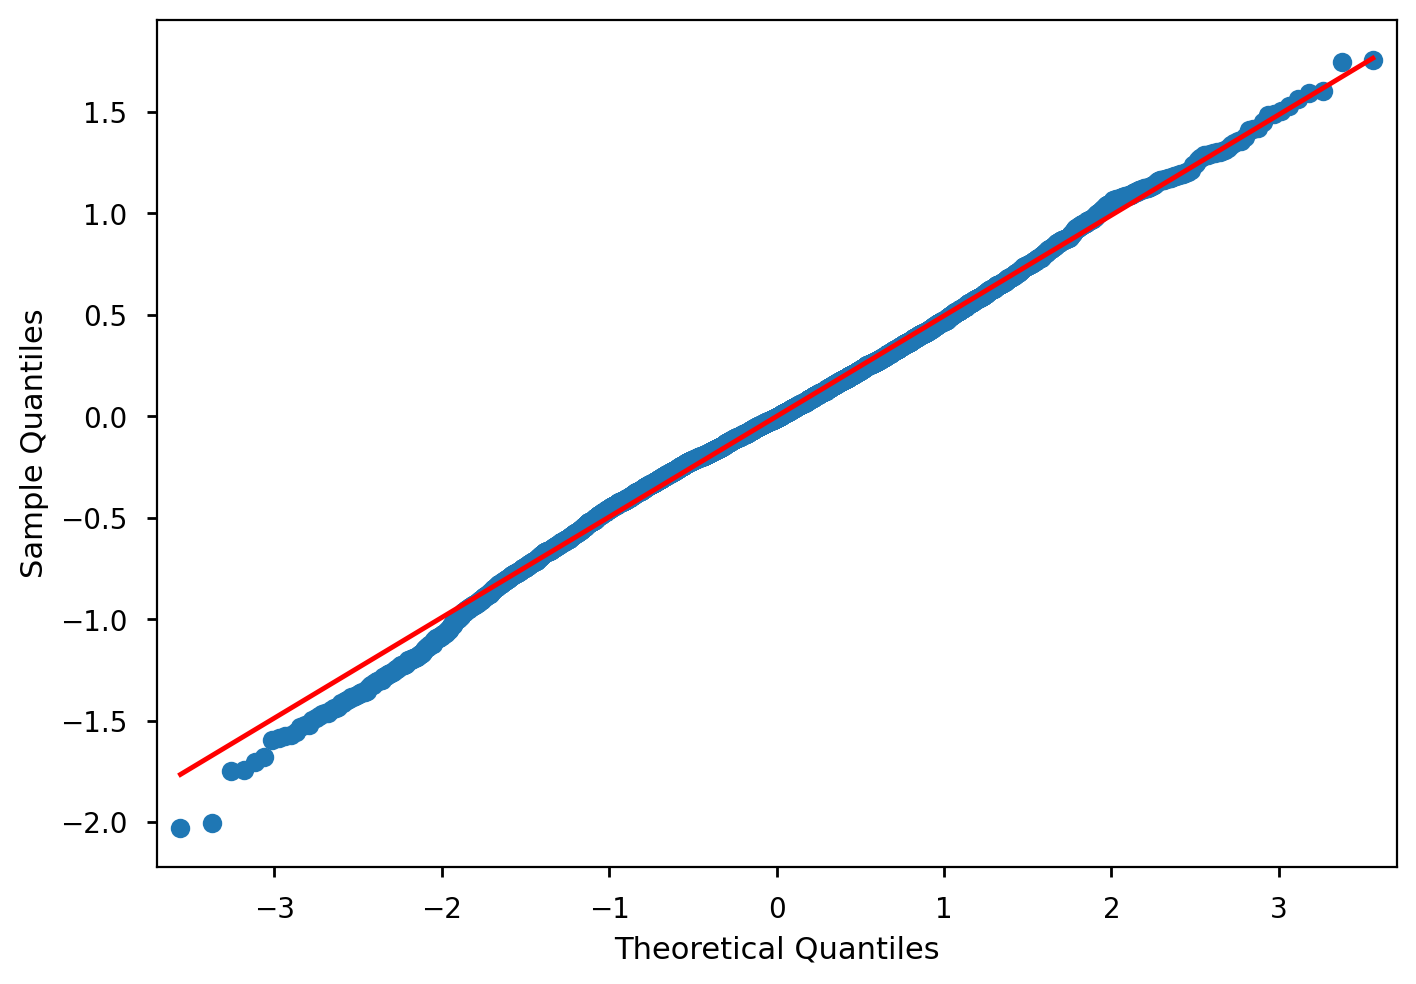

In [87]:
#qq plot
sm.qqplot(model1C.resid,line='s')

In [88]:
#jarque-Bera Test
jarque = stats.jarque_bera(res1C)
jarque.statistic

50.26693584248456

In [89]:
jarque.pvalue

1.2152722207441261e-11

/var/folders/g9/q6tzypkx56110bt4s_wsr1y40000gn/T/ipykernel_74044/3714006240.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(carsdata["price_in_USD"], hist = False, kde = True,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/var/folders/g9/q6tzypkx56110bt4s_wsr1y40000gn/T/ipykernel_74044/3714006240.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seab

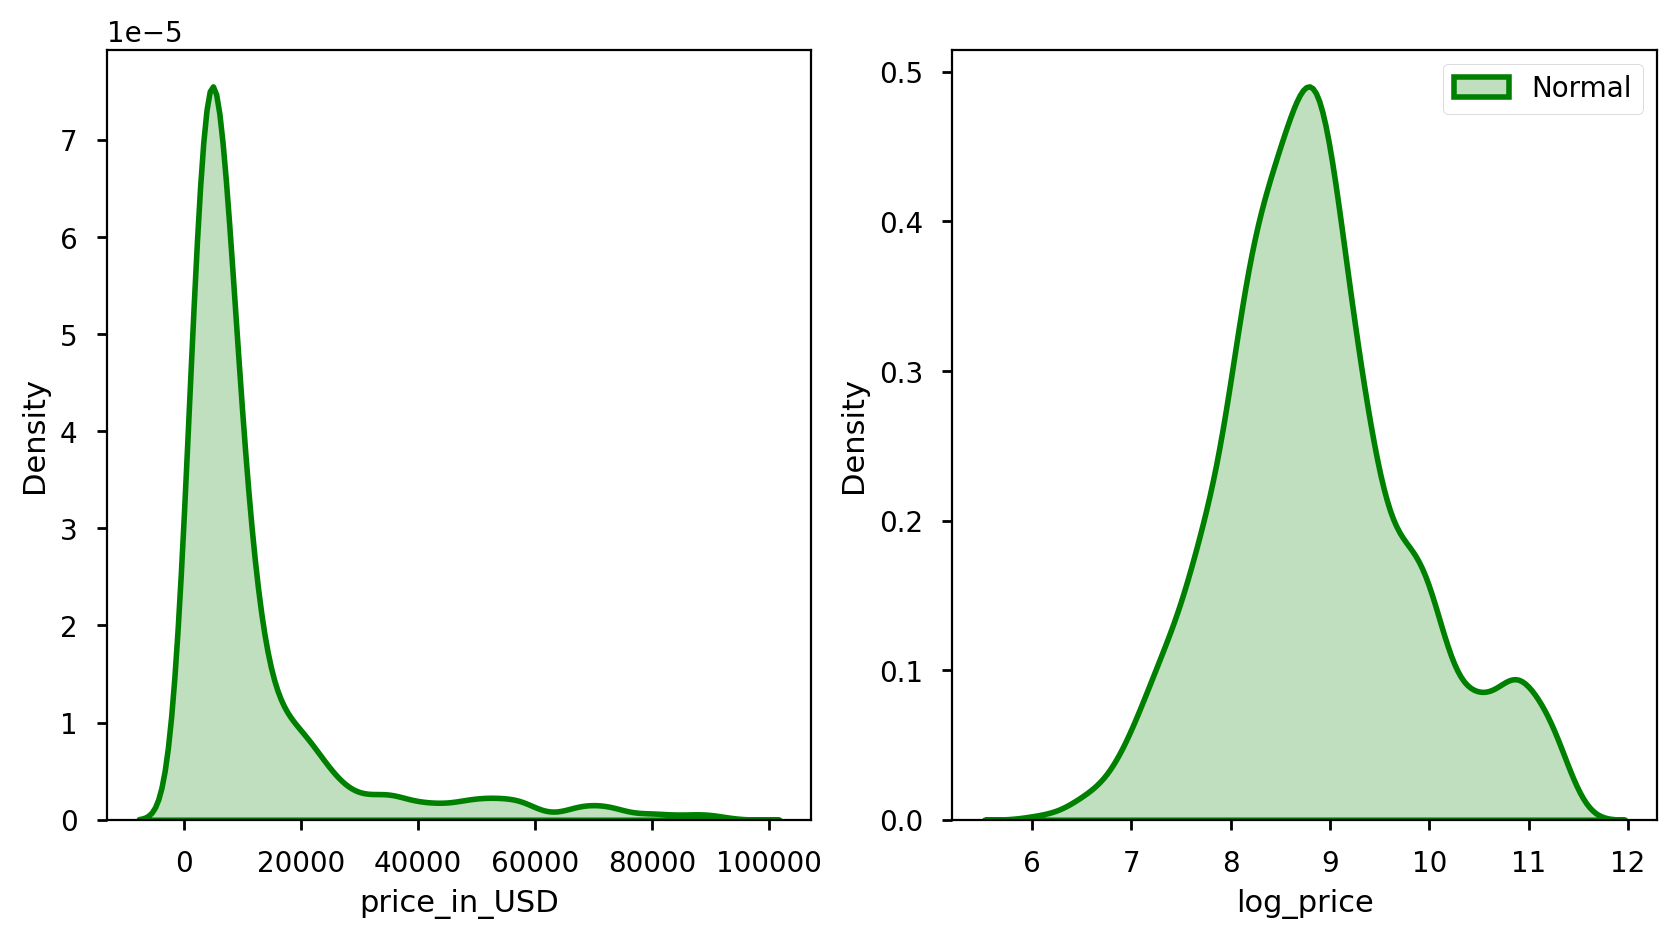

In [90]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(carsdata["price_in_USD"], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(carsdata["log_price"], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

Natural-Log transformation was not enough to eliminate non-normality

<b> NONLINEARITY BETWEEN X AND Y </B>

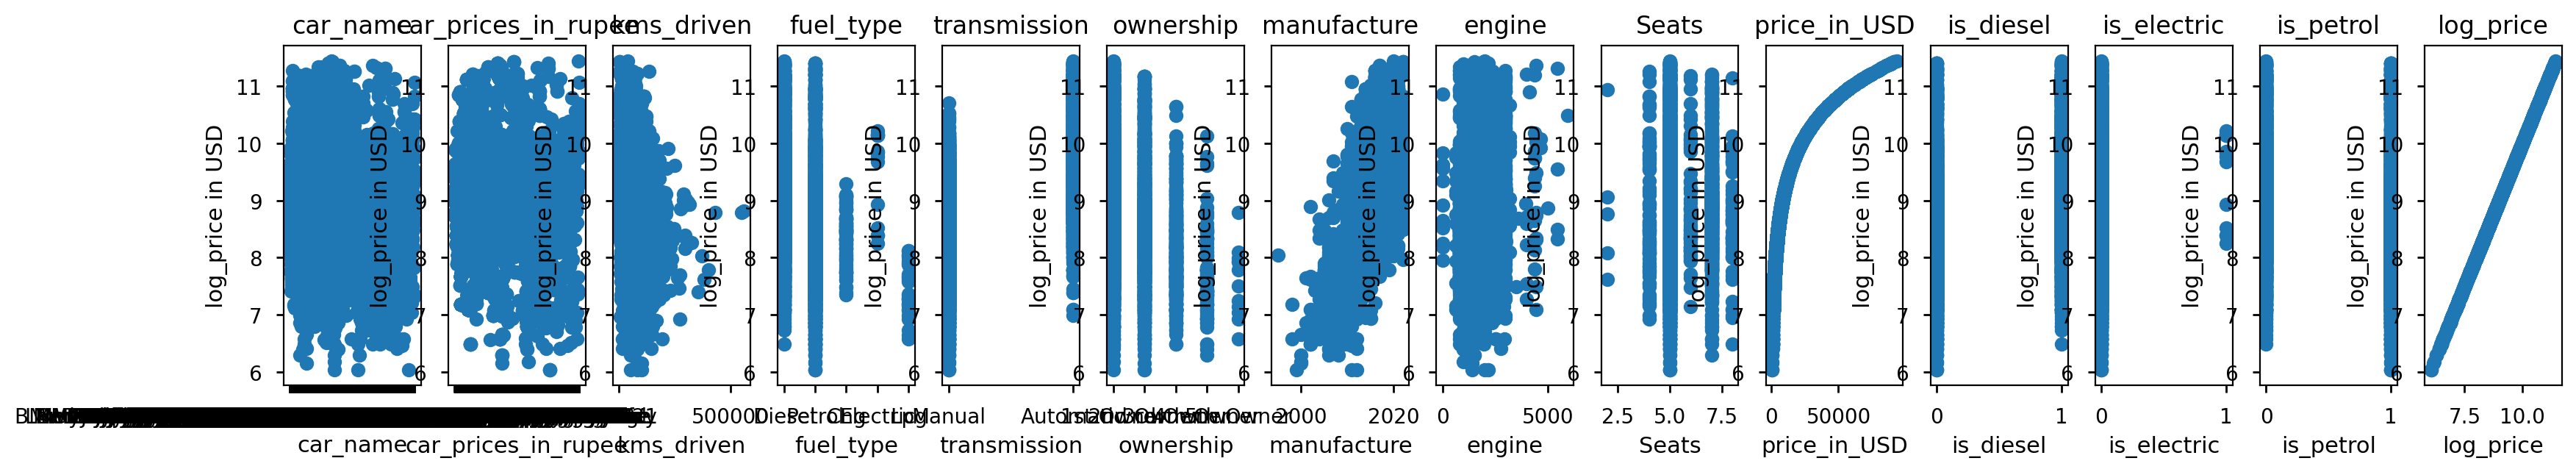

In [91]:
#pair-wise scatter plot between y and predictors
plt.figure(figsize=(20, 3))

for i, col in enumerate(carsdata.columns):
    plt.subplot(1, 14, i+1)
    x = carsdata[col]
    y = carsdata['log_price']
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('log_price in USD')


<b> OPTION 2: BOX-COX TRANSFORMATION</B>

Lambda value used for Transformation: -0.13491936524519552


/var/folders/g9/q6tzypkx56110bt4s_wsr1y40000gn/T/ipykernel_74044/720893439.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(carsdata["price_in_USD"], hist = False, kde = True,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/var/folders/g9/q6tzypkx56110bt4s_wsr1y40000gn/T/ipykernel_74044/720893439.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seabo

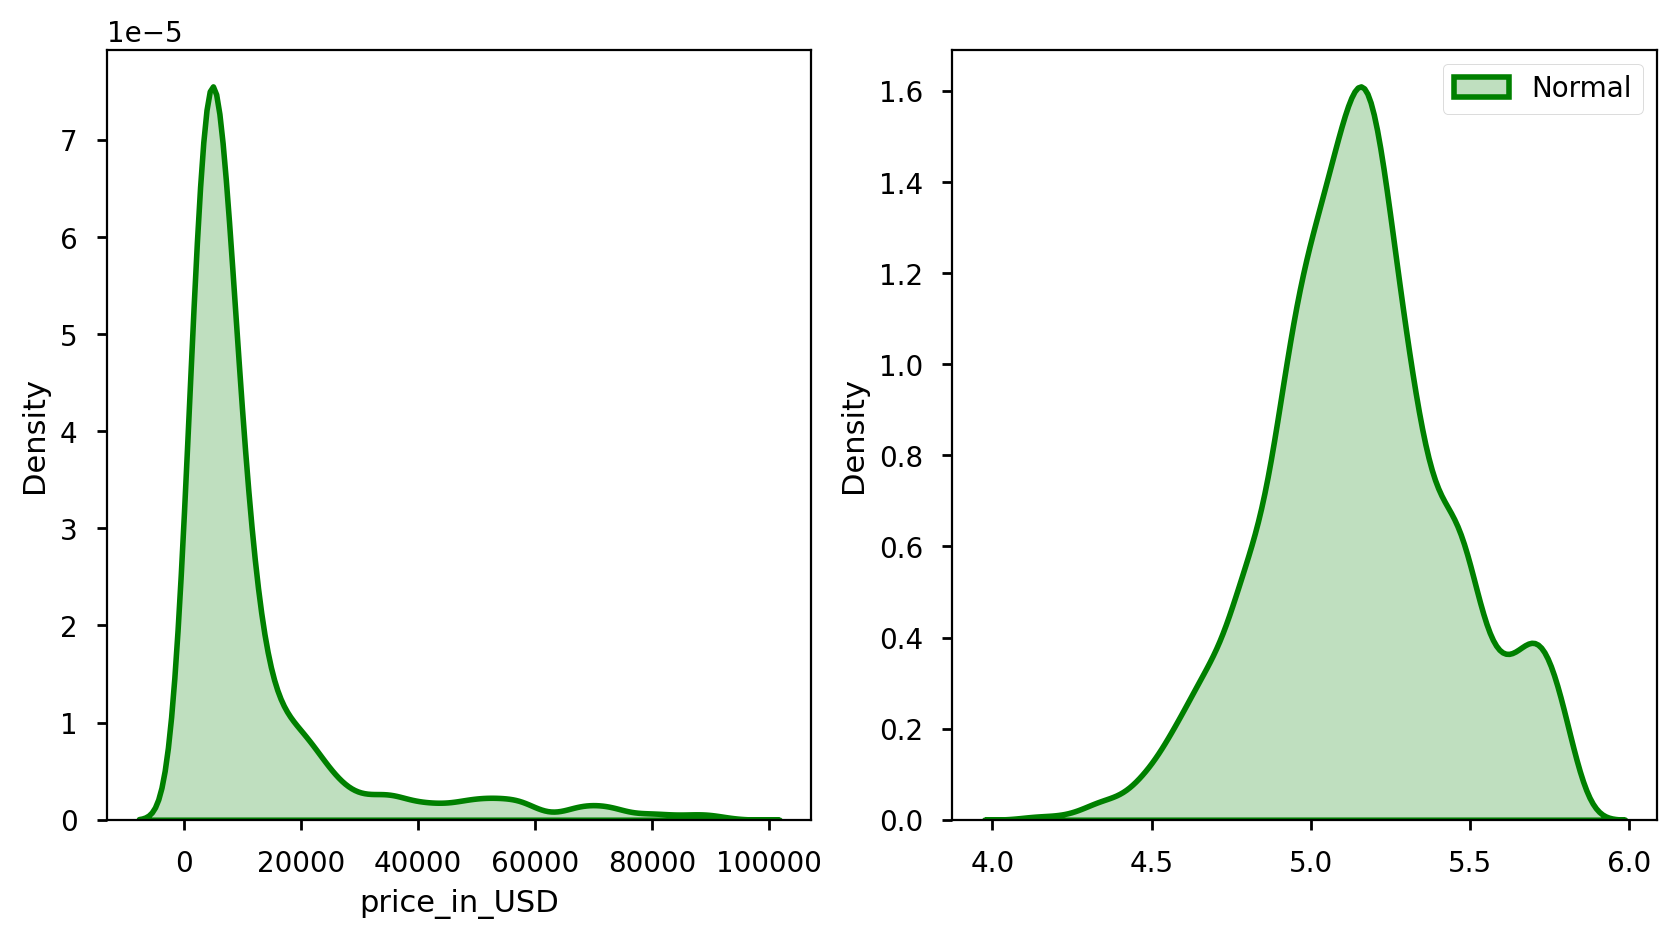

In [92]:
# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(carsdata["price_in_USD"])

# adding the transformed Y to the dataframe 
carsdata['box_price']=fitted_data

# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(carsdata["price_in_USD"], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
 
print(f"Lambda value used for Transformation: {fitted_lambda}")

In [93]:
model1D = smf.ols('box_price~manufacture+engine+Seats+C(fuel_type)+C(transmission)+C(ownership)',data=carsdata).fit()
model1D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              box_price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     1326.
Date:                Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:15:36   Log-Likelihood:                 2741.9
No. Observations:                5423   AIC:                            -5458.
Df Residuals:                    5410   BIC:                            -5372.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -75.1121      1.169    -64.241      0.000     -77.404     -72.820
C(fuel_type)[T.Diesel]        0.1773      0.017     10.606      0.000       0.145       0.210
C(fuel_type)[T.Electric]     -0.1126      0.043     -2.642      0.008      -0.196      -0.029
C(fuel_type)[T.Lpg]          -0.0768      0.032     -2.380      0.017      -0.140      -0.014
C(fuel_type)[T.Petrol]        0.0378      0.017      2.274      0.023       0.005       0.070
C(transmission)[T.Manual]    -0.2899      0.005    -61.307      0.000      -0.299      -0.281
C(ownership)[T.2nd Owner]    -0.0172      0.005     -3.455      0.001      -0.027      -0.007
C(ownership)[T.3rd Owner]    -0.0587      0.009     -6.886      0.000      -0.075      -0.042
C(ownership)[T.4th Owner]    -0.1055      0.016     -6.410      0.000      -0.138      -0.073
C(ownership)[T.5th Owner]    -0.0624      0.042     -1.470      0.142      -0.146       0.021
manufacture                   0.0399      0.001     68.831      0.000       0.039       0.041
engine                     2.299e-05   3.54e-06      6.490      0.000     1.6e-05    2.99e-05
Seats                         0.0057      0.003      2.048      0.041       0.000       0.011
==============================================================================
Omnibus:                      123.088   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.267
Skew:                          -0.274   Prob(JB):                     1.30e-36
Kurtosis:                       3.657   Cond. No.                     1.50e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b> HETEROCEDASTICITY </B>


Text(0.5, 1.0, 'Fitted Values vs. Residuals after Box-Cox transformation on y')

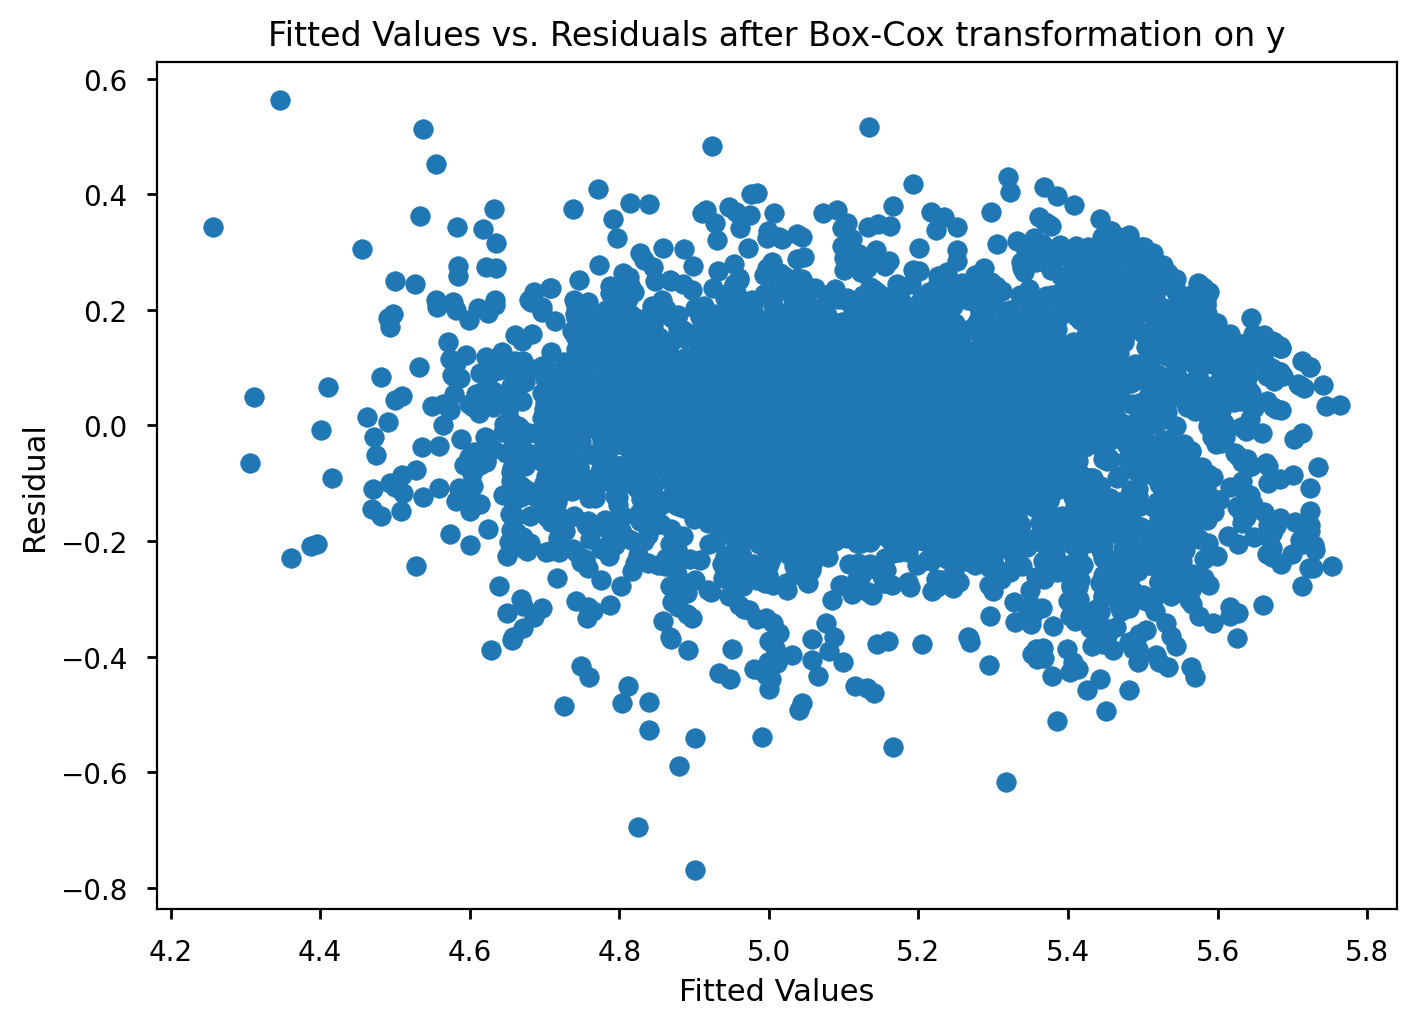

In [94]:
fitted1D = model1D.fittedvalues
res1D = model1D.resid
plt.scatter(fitted1D,res1D)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals after Box-Cox transformation on y")

In [95]:
#Breusch-Pagan test
bp_test = het_breuschpagan(model1D.resid, model1D.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 353.112486347642, 'LM-Test p-value': 3.0919726295141243e-68}


Box-Cox transformation was not enough to eliminate heterocedasticity

<b> NORMALITY</B>

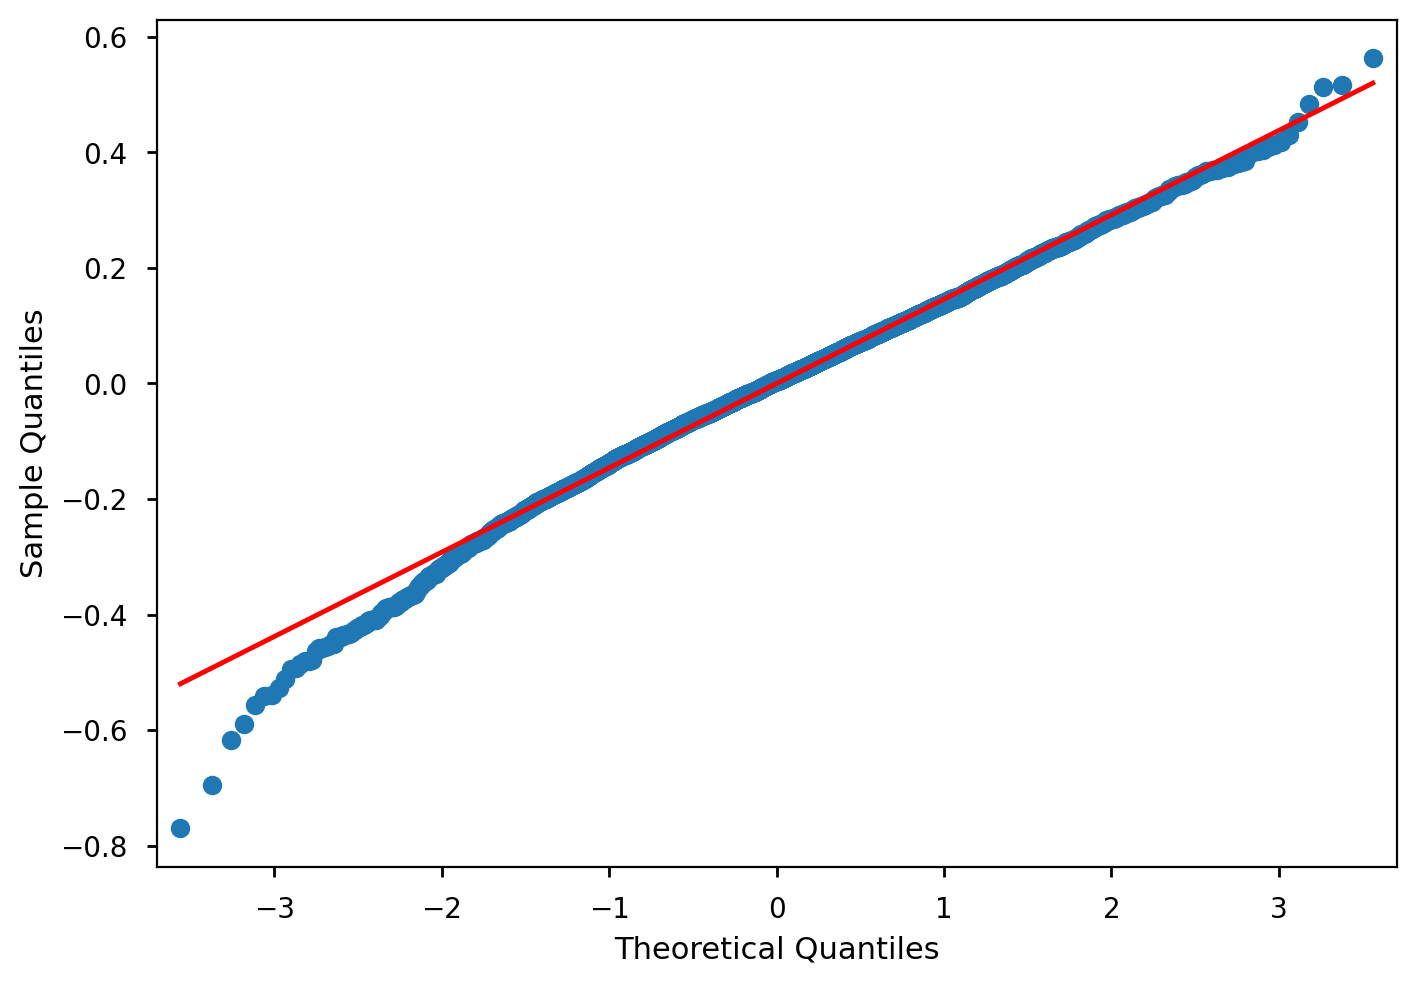

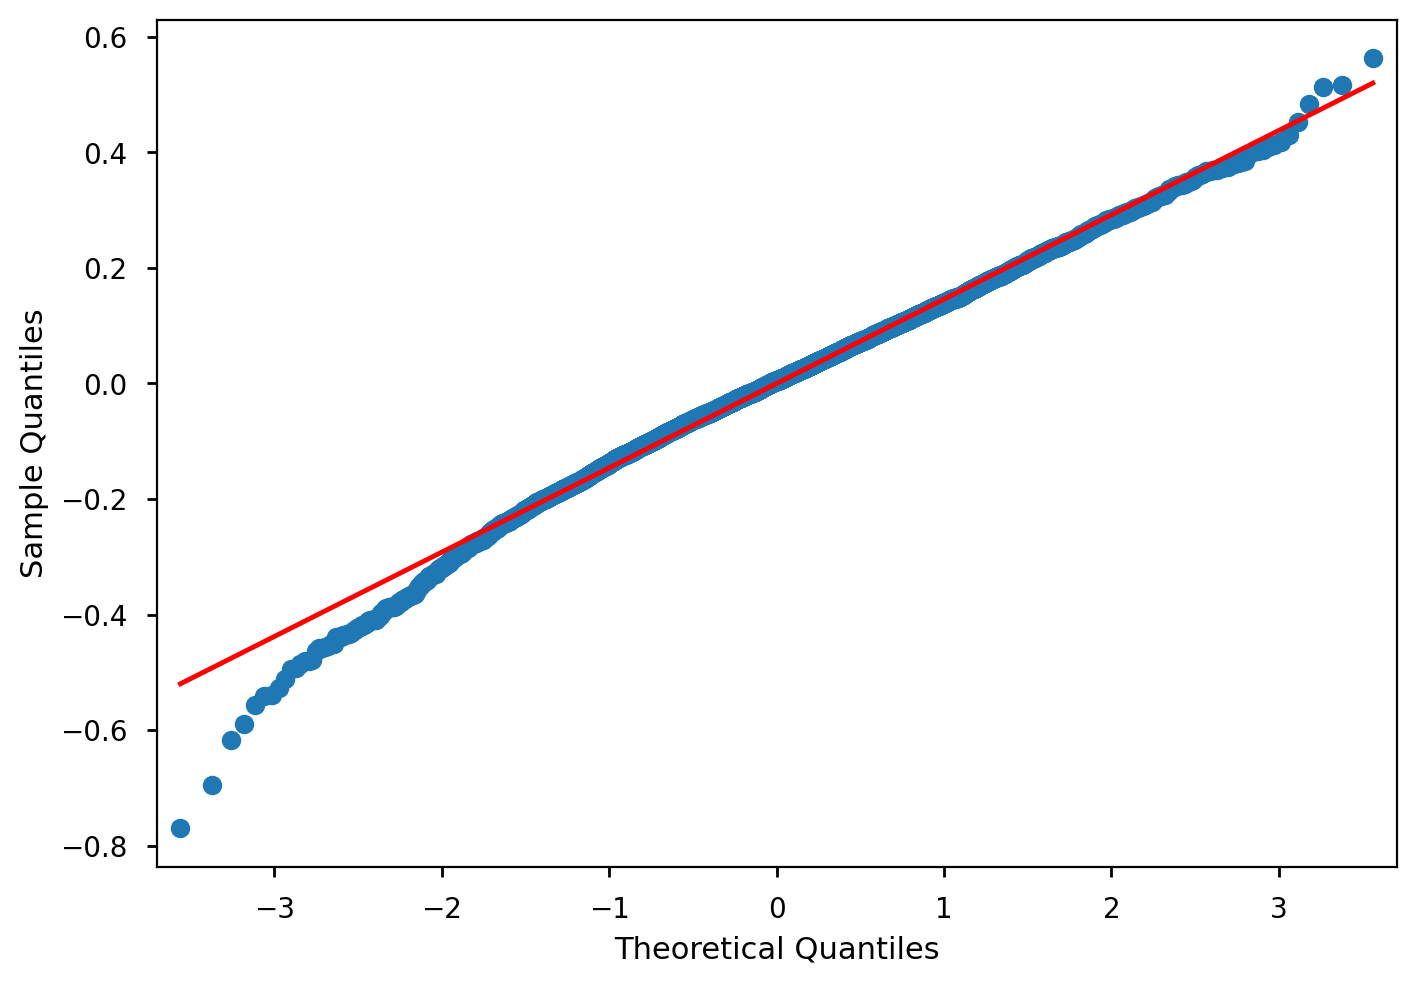

In [96]:
#qq plot
sm.qqplot(model1D.resid,line='s')

In [97]:
#jarque-Bera Test
jarque = stats.jarque_bera(res1D)
jarque.statistic

165.26714430181104

In [98]:
jarque.pvalue

1.2962703724379717e-36

<b> NONLINEARITY BETWEEN X AND Y </B>

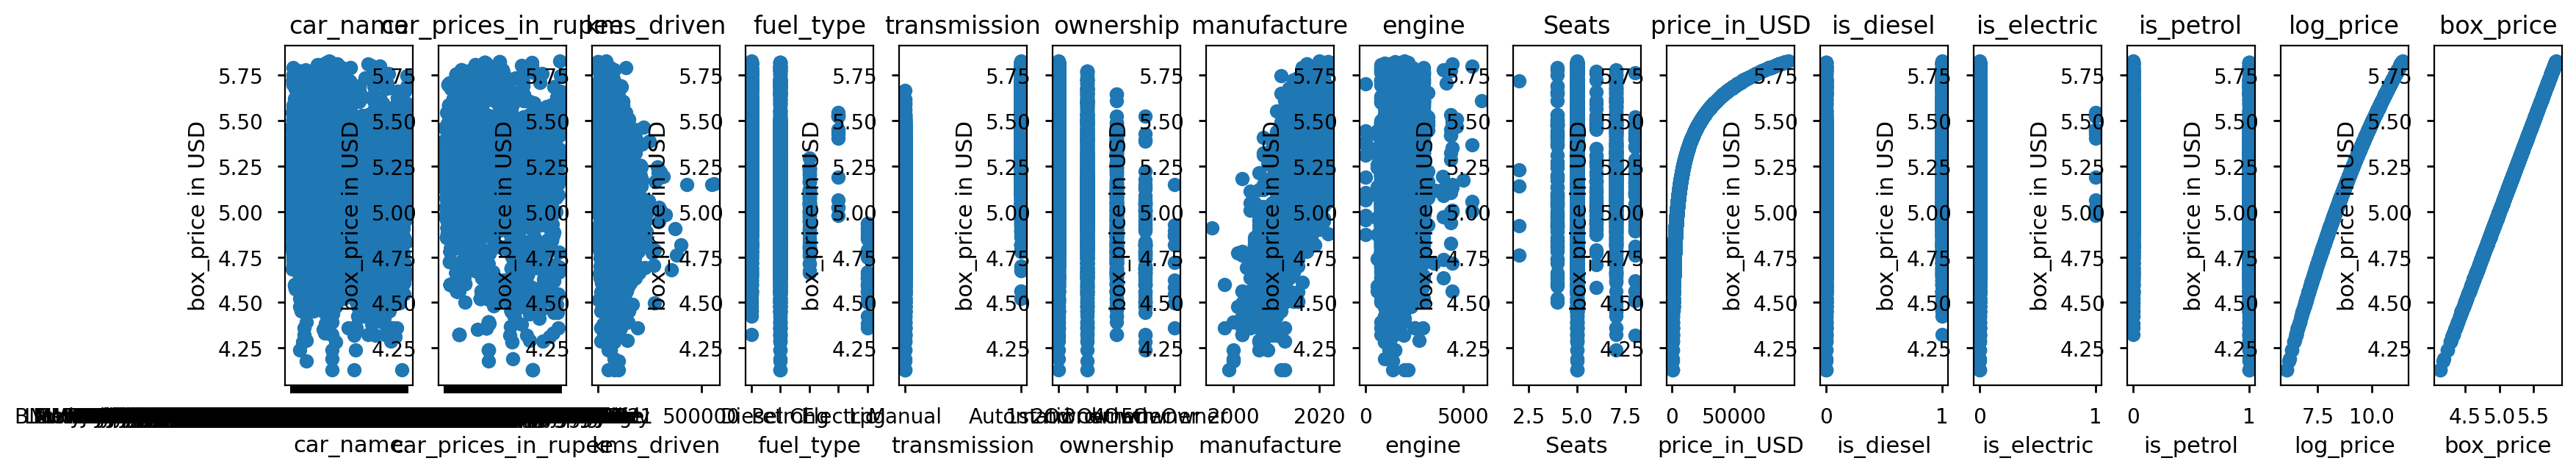

In [99]:
#pair-wise scatter plot between y and predictors
plt.figure(figsize=(20, 3))

for i, col in enumerate(carsdata.columns):
    plt.subplot(1, 15, i+1)
    x = carsdata[col]
    y = carsdata['box_price']
    plt.plot(x, y, 'o')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('box_price in USD')


<b> DETOUR: USE ROBUST STANDARD ERROR </B>

We will use Robust standard error on the MOdel1D (Box-Cox Transformed model)

In [100]:
#extact HCE variance-coviance matrix
V_HC_1 =model1D.cov_HC0


In [101]:
print(np.round(model1D.get_robustcov_results(cov_type = "HC0").summary2().tables[1], 5))

                              Coef.  Std.Err.         t    P>|t|    [0.025  \
Intercept                 -75.11211   1.27908 -58.72371  0.00000 -77.61961   
C(fuel_type)[T.Diesel]      0.17727   0.01165  15.21819  0.00000   0.15443   
C(fuel_type)[T.Electric]   -0.11258   0.05481  -2.05383  0.04004  -0.22003   
C(fuel_type)[T.Lpg]        -0.07678   0.02658  -2.88904  0.00388  -0.12888   
C(fuel_type)[T.Petrol]      0.03779   0.01152   3.27961  0.00105   0.01520   
C(transmission)[T.Manual]  -0.28986   0.00548 -52.84975  0.00000  -0.30061   
C(ownership)[T.2nd Owner]  -0.01724   0.00512  -3.36596  0.00077  -0.02728   
C(ownership)[T.3rd Owner]  -0.05869   0.00844  -6.95472  0.00000  -0.07523   
C(ownership)[T.4th Owner]  -0.10555   0.01865  -5.65953  0.00000  -0.14211   
C(ownership)[T.5th Owner]  -0.06245   0.04405  -1.41777  0.15632  -0.14880   
manufacture                 0.03985   0.00063  62.83974  0.00000   0.03861   
engine                      0.00002   0.00000   6.18672  0.00000

All the predictors are significant for describing price.
We will continue the model selection process whit this as the full model despite the violation of the heteroscedasticity

# Model 2

In [102]:
model2 = smf.ols('box_price~manufacture+Seats+engine+C(fuel_type)+C(transmission)+C(ownership)',data=carsdata).fit()

<b> HETEROCEDASTICITY </B>


Text(0.5, 1.0, 'Fitted Values vs. Residuals after Box-Cox transformation on y')

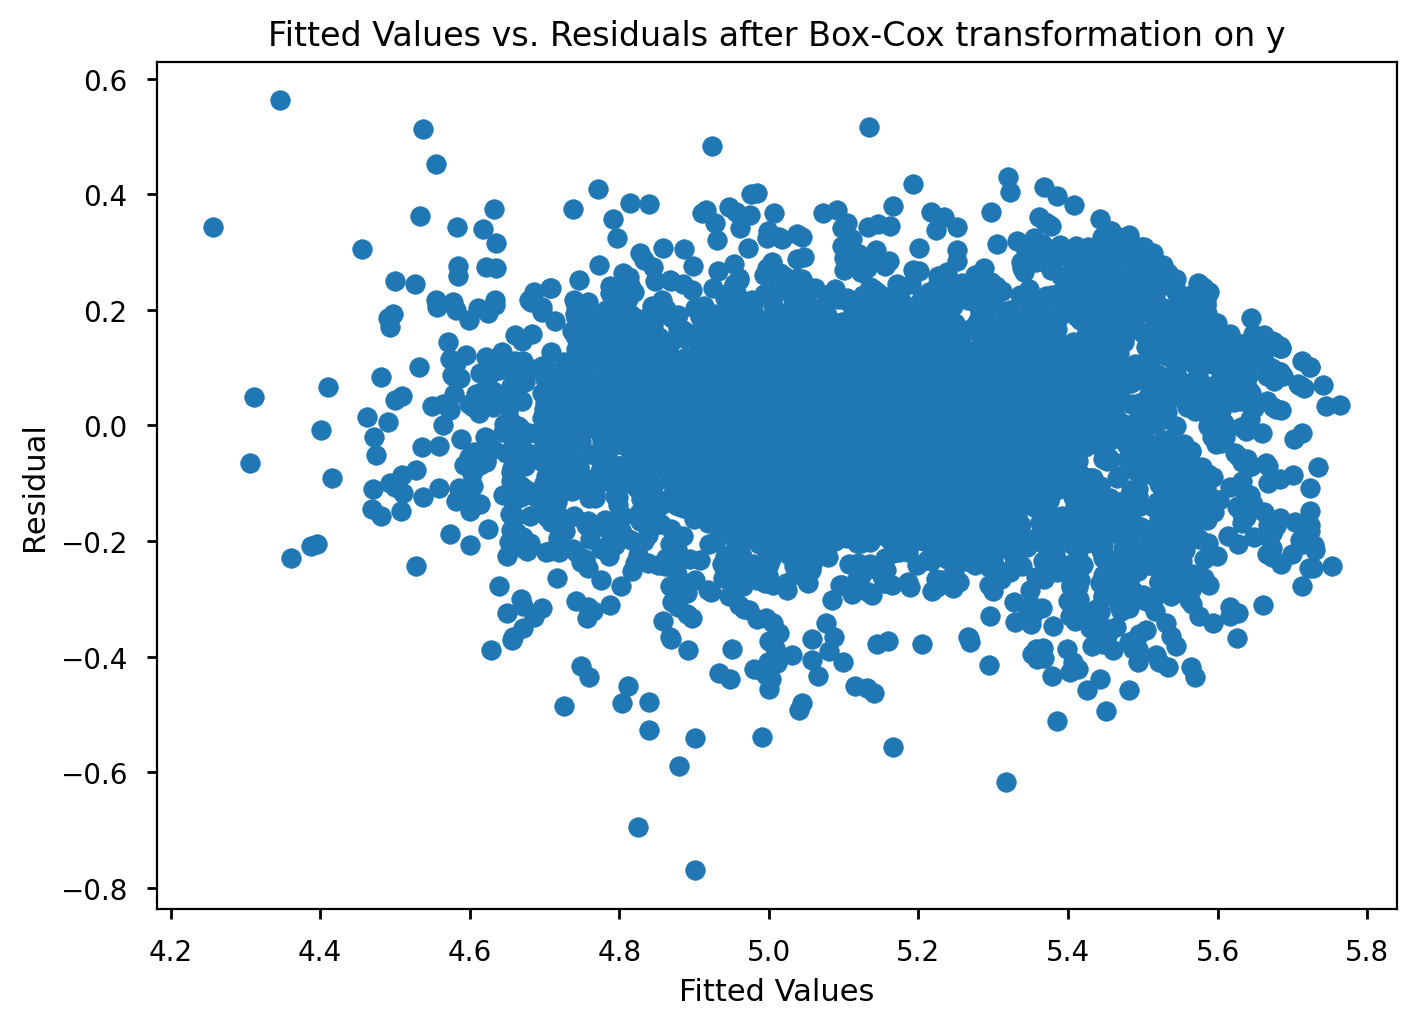

In [103]:
fitted2 = model2.fittedvalues
res2 = model2.resid
plt.scatter(fitted2,res2)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals after Box-Cox transformation on y")

In [104]:
#Breusch-Pagan test
bp_test = het_breuschpagan(model2.resid, model2.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 353.11248634725183, 'LM-Test p-value': 3.0919726301003664e-68}


<b> ROBUST STANDARD ERROR </B>

In [105]:
#extact HCE variance-coviance matrix
V_HC_1 =model2.cov_HC0
print(np.round(model2.get_robustcov_results(cov_type = "HC0").summary2().tables[0], 5))
print(np.round(model2.get_robustcov_results(cov_type = "HC0").summary2().tables[1], 5))

                     0                 1                    2           3
0               Model:               OLS      Adj. R-squared:       0.746
1  Dependent Variable:         box_price                 AIC:  -5457.8274
2                Date:  2023-10-11 22:15                 BIC:  -5372.0482
3    No. Observations:              5423      Log-Likelihood:      2741.9
4            Df Model:                12         F-statistic:       1150.
5        Df Residuals:              5410  Prob (F-statistic):        0.00
6           R-squared:             0.746               Scale:    0.021350
                              Coef.  Std.Err.         t    P>|t|    [0.025  \
Intercept                 -75.11211   1.27908 -58.72371  0.00000 -77.61961   
C(fuel_type)[T.Diesel]      0.17727   0.01165  15.21819  0.00000   0.15443   
C(fuel_type)[T.Electric]   -0.11258   0.05481  -2.05383  0.04004  -0.22003   
C(fuel_type)[T.Lpg]        -0.07678   0.02658  -2.88904  0.00388  -0.12888   
C(fuel_type)[T.Pet

# ANOVA

In [106]:
sm.stats.anova_lm(model2.get_robustcov_results(cov_type = "HC0"), typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(fuel_type),4.0,50.149762,12.537440,587.227884,0.000000e+00
C(transmission),1.0,150.386164,150.386164,7043.778095,0.000000e+00
C(ownership),4.0,36.598955,9.149739,428.554918,2.875462e-321
manufacture,1.0,101.568153,101.568153,4757.243029,0.000000e+00
Seats,1.0,0.182762,0.182762,8.560210,3.450187e-03
engine,1.0,0.899324,0.899324,42.122475,9.337615e-11
Residual,5410.0,115.504653,0.021350,NaN,NaN


We can choose Model 2 with all the predictors (box_price ~ manufacture + Seats + engine + fuel_type + transmission + ownership)

Notes:
1. The model has a Box-Cox transformation on the price with Lamda = -0.13491936524519552
2. Despite of the Box-Cox transformation, the residuals have significant evidence of heteroscedasticity and the dependant variable has significant evidence ofnon-normality. 